In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path

path = str(Path.cwd().parent)
sys.path.append(path)

In [2]:
import cv2
import logging
import numpy as np
import swifter
import warnings

from bootstrap import bootstrap
from constant import SETTINGS
from datatype.dataset import Dataset
from datatype.settings import Settings
from datatype.spectrogram import (
    pad,
    Linear,
    Mel,
    Spectrogram
)
from io import BytesIO
from logger import logger
from PIL import Image, ImageOps
from skimage import filters

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def create_spectrogram(segment, settings):
    spectrogram = Spectrogram()
    spectrogram.strategy = Mel(segment, settings)
    return spectrogram.generate()

In [5]:
def create_image(spectrogram):
    buffer = BytesIO()
    image = Image.fromarray(~spectrogram)

    # flip = ImageOps.flip(image)
    # flip.save(buffer, format='png')

    image.save(buffer, format='png')
    
    return buffer.getvalue()

In [6]:
def crop_image(image):
    wrapper = BytesIO(image)
    image = Image.open(wrapper)

    x = image.width

    area = (x / 3.5, 100, x / 3.5, 0)
    crop = ImageOps.crop(image, area)

    buffer = BytesIO()
    crop.save(buffer, format='png')

    return buffer.getvalue()

In [7]:
def resize_spectrogram(spectrogram, factor=10):
    x, y = np.shape(spectrogram)
    shape = [int(np.log(y) * factor), x]

    return np.array(
        Image
        .fromarray(spectrogram)
        .resize(shape, Image.Resampling.LANCZOS)
    )

In [8]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [9]:
path = SETTINGS.joinpath('spectrogram.json')
settings = Settings.from_file(path)

In [10]:
minimum = 10
maximum = minimum + 10

subset = dataframe.iloc[minimum:maximum]
# subset = dataframe.sample(40)

In [11]:
subset['spectrogram'] = (
    subset['segment']
    .swifter
    .apply(
        lambda x: create_spectrogram(x, settings)
    )
)

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# subset['spectrogram'] = (
#     subset['spectrogram']
#     .swifter
#     .apply(
#         lambda x: resize_spectrogram(x)
#     )
# )

In [13]:
subset['image'] = (
    subset['spectrogram']
    .swifter
    .apply(
        lambda x: create_image(x)
    )
)

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

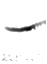

In [19]:
sample = subset.image.iloc[9]
image = Image.open(BytesIO(sample))

display(image)